In [0]:
#@title DCGAN { display-mode: "both" }
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
tf.logging.set_verbosity(tf.logging.ERROR)
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [0]:
# Training Params
num_steps = 500 #@param {type: "integer"}
batch_size = 128
lr_generator = 0.002
lr_discriminator = 0.002

# Network Params
image_dim = 784 # 28*28 pixels * 1 channel
noise_dim = 100 # Noise data points

In [0]:
# Build Networks
# Network Inputs
noise_input = tf.placeholder(tf.float32, shape=[None, noise_dim])
real_image_input = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
batch_s = tf.placeholder(tf.int32)
# A boolean to indicate batch normalization if it is training or inference time
is_training = tf.placeholder(tf.bool)

#LeakyReLU activation
def leakyrelu(x, alpha=0.2):
    return 0.5 * (1 + alpha) * x + 0.5 * (1 - alpha) * abs(x)

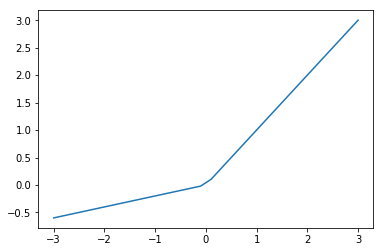

In [5]:
a = np.linspace(-3, 3, 30)
a_out = leakyrelu(a)
plt.plot(a, a_out)

In [0]:
# def generator(x, reuse=False):
#     with tf.variable_scope('Generator', reuse=reuse):
#         # TensorFlow Layers automatically create variables and calculate their
#         # shape, based on the input.
#         x = tf.layers.dense(x, units=7 * 7 * 128)
#         x = tf.layers.batch_normalization(x, training=is_training)
#         x = tf.nn.relu(x)
#         # Reshape to a 4-D array of images: (batch, height, width, channels)
#         # New shape: (batch, 7, 7, 128)
#         x = tf.reshape(x, shape=[-1, 7, 7, 128])
#         # Deconvolution, image shape: (batch, 14, 14, 64)
#         x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, padding='same')
#         x = tf.layers.batch_normalization(x, training=is_training)
#         x = tf.nn.relu(x)
#         # Deconvolution, image shape: (batch, 28, 28, 1)
#         x = tf.layers.conv2d_transpose(x, 1, 5, strides=2, padding='same')
#         # Apply tanh for better stability - clip values to [-1, 1].
#         x = tf.nn.tanh(x)
#         return x

# def generator(x, batch_size, reuse=False):
#     with tf.variable_scope('Generator', reuse=reuse):
#         num_neuron = 7 * 7 * 64
#         w_fc = tf.Variable(tf.truncated_normal(shape=[noise_dim, num_neuron], stddev=0.1), name='weights_fc')
#         b_fc = tf.Variable(tf.constant(0.1, shape=[num_neuron]), name='bias_fc')
#         layer_1 = tf.matmul(x, w_fc) + b_fc
#         layer_1_bn = tf.layers.batch_normalization(layer_1, training=is_training)
#         layer_1_op = tf.nn.relu(layer_1_bn)
#         x_imgs = tf.reshape(layer_1_op, shape=[batch_size, 7, 7, 64], name='layer1_imgs')
#         w_c1 = tf.Variable(tf.truncated_normal(shape=[5, 5, 32, 64], stddev=0.1), name='weights_c1')
#         b_c1 = tf.Variable(tf.constant(0., shape=[32]), name='bias_c1')
#         layer_c1 = tf.nn.conv2d_transpose(x_imgs, w_c1, output_shape=[batch_size, 14, 14, 32], strides=[1, 2, 2, 1], padding='SAME') + b_c1
# #         layer_c1 = tf.layers.conv2d_transpose(x_imgs, 64, 5, strides=2, padding='same')
#         layer_c1_bn = tf.layers.batch_normalization(layer_c1, training=is_training)
#         layer_c1_op = tf.nn.relu(layer_c1_bn)
#         w_c2 = tf.Variable(tf.truncated_normal(shape=[5, 5, 1, 32], stddev=0.1), name='weights_c2')
#         b_c2 = tf.Variable(tf.constant(0., shape=[1]), name='bias_c2')
#         layer_c2 = tf.nn.conv2d_transpose(layer_c1_op, w_c2, output_shape=[batch_size, 28, 28, 1], strides=[1, 2, 2, 1], padding='SAME') + b_c2
# #         layer_c2 = tf.layers.conv2d_transpose(layer_c1_op, 1, 5, strides=2, padding='same')
#         x_op = tf.nn.tanh(layer_c2, name='output_gen')
#         return x_op
    

In [0]:
def generator(x, batch_size, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        num_neuron = 7 * 7 * 64
        w_fc = tf.get_variable(name='weights_fc', shape=[noise_dim, num_neuron], initializer=tf.initializers.truncated_normal(stddev=0.1))
        b_fc = tf.get_variable(name='bias_fc', shape=[num_neuron], initializer=tf.zeros_initializer())
        layer_1 = tf.matmul(x, w_fc) + b_fc
        layer_1_bn = tf.layers.batch_normalization(layer_1, training=is_training)
        layer_1_op = tf.nn.relu(layer_1_bn)
        x_imgs = tf.reshape(layer_1_op, shape=[batch_size, 7, 7, 64], name='layer1_imgs')
        w_c1 = tf.get_variable(name='weights_c1', shape=[5, 5, 32, 64], initializer=tf.initializers.truncated_normal(stddev=0.1))
        b_c1 = tf.get_variable(name='bias_c1', shape=[32], initializer=tf.zeros_initializer())
        layer_c1 = tf.nn.conv2d_transpose(x_imgs, w_c1, output_shape=[batch_size, 14, 14, 32], strides=[1, 2, 2, 1], padding='SAME') + b_c1
#         layer_c1 = tf.layers.conv2d_transpose(x_imgs, 64, 5, strides=2, padding='same')
        layer_c1_bn = tf.layers.batch_normalization(layer_c1, training=is_training)
        layer_c1_op = tf.nn.relu(layer_c1_bn)
        w_c2 = tf.get_variable(name='weights_c2', shape=[5, 5, 1, 32], initializer=tf.initializers.truncated_normal(stddev=0.1))
        b_c2 = tf.get_variable(name='bias_c2', shape=[1], initializer=tf.zeros_initializer())
        layer_c2 = tf.nn.conv2d_transpose(layer_c1_op, w_c2, output_shape=[batch_size, 28, 28, 1], strides=[1, 2, 2, 1], padding='SAME') + b_c2
#         layer_c2 = tf.layers.conv2d_transpose(layer_c1_op, 1, 5, strides=2, padding='same')
        x_op = tf.nn.tanh(layer_c2, name='output_gen')
        return x_op

In [0]:
# with tf.variable_scope('Generator', reuse=False):
#     w_fc = tf.get_variable(name='weights_fc', shape=[100, 3136], initializer=tf.initializers.truncated_normal(stddev=0.1))
# w_fc

In [0]:
# w_fc

In [9]:
gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
gen_vars

[]

In [0]:
# x = noise_input
# num_neuron = 7 * 7 * 128
# w_fc = tf.Variable(tf.truncated_normal(shape=[noise_dim, num_neuron], stddev=0.1), name='weights_fc')
# b_fc = tf.Variable(tf.constant(0.1, shape=[num_neuron]), name='bias_fc')
# layer_1 = tf.matmul(x, w_fc) + b_fc
# layer_1_bn = tf.layers.batch_normalization(layer_1, training=is_training)
# layer_1_op = tf.nn.relu(layer_1_bn)
# x_imgs = tf.reshape(layer_1_op, shape=[-1, 7, 7, 128], name='layer1_imgs')
# w_c1 = tf.Variable(tf.truncated_normal(shape=[5, 5, 64, 128]), name='weights_c1')
# b_c1 = tf.Variable(tf.constant(0.1, shape=[64]), name='bias_c1')
# layer_c1 = tf.nn.conv2d_transpose(x_imgs, w_c1, output_shape=[-1, 14, 14, 64], strides=[1, 2, 2, 1], padding='SAME') + b_c1
# # layer_c1 = tf.layers.conv2d_transpose(x_imgs, 64, 5, strides=2, padding='same')
# layer_c1_bn = tf.layers.batch_normalization(layer_c1, training=is_training)
# layer_c1_op = tf.nn.relu(layer_c1_bn)
# w_c2 = tf.Variable(tf.truncated_normal(shape=[5, 5, 1, 64]), name='weights_c2')
# b_c2 = tf.Variable(tf.constant(0.1, shape=[1]), name='bias_c2')
# layer_c2 = tf.nn.conv2d_transpose(layer_c1_op, w_c2, output_shape=[-1, 28, 28, 1], strides=[1, 2, 2, 1], padding='SAME') + b_c2
# # layer_c2 = tf.layers.conv2d_transpose(layer_c1_op, 1, 5, strides=2, padding='same')
# x_op = tf.nn.tanh(layer_c2, name='output_gen')


In [10]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Generator')

[]

In [0]:
def discriminator(x, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        # Typical convolutional neural network to classify images.
        x = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_training)
        x = leakyrelu(x)
        x = tf.layers.conv2d(x, 128, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_training)
        x = leakyrelu(x)
        # Flatten
        x = tf.reshape(x, shape=[-1, 7*7*128])
        x = tf.layers.dense(x, 1024)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = leakyrelu(x)
        # Output 2 classes: Real and Fake images
        x = tf.layers.dense(x, 2)
    return x

In [0]:
# Build Generator Network
gen_sample = generator(noise_input, batch_s, reuse=False)

# Build 2 Discriminator Networks (one from noise input, one from generated samples)
disc_real = discriminator(real_image_input, reuse=False)
disc_fake = discriminator(gen_sample, reuse=True)

# Build the stacked generator/discriminator
stacked_gan = discriminator(gen_sample, reuse=True)

# Build Loss (Labels for real images: 1, for fake images: 0)
# Discriminator Loss for real and fake samples
disc_loss_real = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=disc_real, labels=tf.ones([batch_size], dtype=tf.int32)))
disc_loss_fake = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=disc_fake, labels=tf.zeros([batch_size], dtype=tf.int32)))
# Sum both loss
disc_loss = disc_loss_real + disc_loss_fake
# Generator Loss (The generator tries to fool the discriminator, thus labels are 1)
gen_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=stacked_gan, labels=tf.ones([batch_size], dtype=tf.int32)))

# Build Optimizers
optimizer_gen = tf.train.AdamOptimizer(learning_rate=lr_generator, beta1=0.5, beta2=0.999)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=lr_discriminator, beta1=0.5, beta2=0.999)

# Training Variables for each optimizer
# By default in TensorFlow, all variables are updated by each optimizer, so we
# need to precise for each one of them the specific variables to update.
# Generator Network Variables
gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
# Discriminator Network Variables
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')

# Create training operations
# TensorFlow UPDATE_OPS collection holds all batch norm operation to update the moving mean/stddev
gen_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Generator')
# `control_dependencies` ensure that the `gen_update_ops` will be run before the `minimize` op (backprop)
with tf.control_dependencies(gen_update_ops):
    train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
disc_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Discriminator')
with tf.control_dependencies(disc_update_ops):
    train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)
    
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [0]:
event_path = './Tensorboard'
tf.summary.scalar('disc_loss', disc_loss, collections=['train'])
tf.summary.scalar('gen_loss', gen_loss, collections=['train'])
sum_train = tf.summary.merge_all('train')

In [15]:
gen_vars

[<tf.Variable 'Generator/weights_fc:0' shape=(100, 3136) dtype=float32_ref>,
 <tf.Variable 'Generator/bias_fc:0' shape=(3136,) dtype=float32_ref>,
 <tf.Variable 'Generator/batch_normalization/gamma:0' shape=(3136,) dtype=float32_ref>,
 <tf.Variable 'Generator/batch_normalization/beta:0' shape=(3136,) dtype=float32_ref>,
 <tf.Variable 'Generator/weights_c1:0' shape=(5, 5, 32, 64) dtype=float32_ref>,
 <tf.Variable 'Generator/bias_c1:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'Generator/batch_normalization_1/gamma:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'Generator/batch_normalization_1/beta:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'Generator/weights_c2:0' shape=(5, 5, 1, 32) dtype=float32_ref>,
 <tf.Variable 'Generator/bias_c2:0' shape=(1,) dtype=float32_ref>]

In [16]:
gen_update_ops

[<tf.Operation 'Generator_1/batch_normalization/cond_2/Merge' type=Merge>,
 <tf.Operation 'Generator_1/batch_normalization/cond_3/Merge' type=Merge>,
 <tf.Operation 'Generator_1/batch_normalization_1/AssignMovingAvg' type=AssignSub>,
 <tf.Operation 'Generator_1/batch_normalization_1/AssignMovingAvg_1' type=AssignSub>]

In [17]:
disc_vars

[<tf.Variable 'Discriminator/conv2d/kernel:0' shape=(5, 5, 1, 64) dtype=float32_ref>,
 <tf.Variable 'Discriminator/conv2d/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'Discriminator/batch_normalization/gamma:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'Discriminator/batch_normalization/beta:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'Discriminator/conv2d_1/kernel:0' shape=(5, 5, 64, 128) dtype=float32_ref>,
 <tf.Variable 'Discriminator/conv2d_1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'Discriminator/batch_normalization_1/gamma:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'Discriminator/batch_normalization_1/beta:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'Discriminator/dense/kernel:0' shape=(6272, 1024) dtype=float32_ref>,
 <tf.Variable 'Discriminator/dense/bias:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'Discriminator/batch_normalization_2/gamma:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'Discriminator/batch_normalization_2

In [18]:
disc_update_ops

[<tf.Operation 'Discriminator/batch_normalization/AssignMovingAvg' type=AssignSub>,
 <tf.Operation 'Discriminator/batch_normalization/AssignMovingAvg_1' type=AssignSub>,
 <tf.Operation 'Discriminator/batch_normalization_1/AssignMovingAvg' type=AssignSub>,
 <tf.Operation 'Discriminator/batch_normalization_1/AssignMovingAvg_1' type=AssignSub>,
 <tf.Operation 'Discriminator/batch_normalization_2/cond_2/Merge' type=Merge>,
 <tf.Operation 'Discriminator/batch_normalization_2/cond_3/Merge' type=Merge>,
 <tf.Operation 'Discriminator_1/batch_normalization/AssignMovingAvg' type=AssignSub>,
 <tf.Operation 'Discriminator_1/batch_normalization/AssignMovingAvg_1' type=AssignSub>,
 <tf.Operation 'Discriminator_1/batch_normalization_1/AssignMovingAvg' type=AssignSub>,
 <tf.Operation 'Discriminator_1/batch_normalization_1/AssignMovingAvg_1' type=AssignSub>,
 <tf.Operation 'Discriminator_1/batch_normalization_2/cond_2/Merge' type=Merge>,
 <tf.Operation 'Discriminator_1/batch_normalization_2/cond_3/Merg

In [19]:
# gen_sample.get_shape()
labels=tf.ones([batch_size], dtype=tf.int32)
labels.get_shape()

TensorShape([Dimension(128)])

In [20]:
# Start Training
# Start a new TF session
sess = tf.Session()

summ_writer = tf.summary.FileWriter(event_path)
summ_writer.add_graph(sess.graph)
# Run the initializer
sess.run(init)
    
# Training
for i in range(1, num_steps+1):

    # Prepare Input Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)
    batch_x = np.reshape(batch_x, newshape=[-1, 28, 28, 1])
    # Rescale to [-1, 1], the input range of the discriminator
    batch_x = batch_x * 2. - 1.

    # Discriminator Training
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])
    # batch_s: batch_size, 
    _, dl, rs = sess.run([train_disc, disc_loss, sum_train], feed_dict={real_image_input: batch_x, noise_input: z, batch_s: batch_size, is_training:True})
    summ_writer.add_summary(rs, global_step=i)

    # Generator Training
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])
    _, gl = sess.run([train_gen, gen_loss], feed_dict={noise_input: z, batch_s: batch_size, is_training:True})
    
    if i % 50 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))

Step 1: Generator Loss: 2.868849, Discriminator Loss: 1.985915
Step 50: Generator Loss: 1.116332, Discriminator Loss: 1.042294
Step 100: Generator Loss: 1.548643, Discriminator Loss: 0.733522
Step 150: Generator Loss: 2.516666, Discriminator Loss: 0.283446
Step 200: Generator Loss: 2.548098, Discriminator Loss: 0.950428
Step 250: Generator Loss: 1.929592, Discriminator Loss: 0.774014
Step 300: Generator Loss: 1.862185, Discriminator Loss: 0.711674
Step 350: Generator Loss: 2.008067, Discriminator Loss: 0.624357
Step 400: Generator Loss: 1.360406, Discriminator Loss: 1.026059
Step 450: Generator Loss: 1.690673, Discriminator Loss: 0.879161
Step 500: Generator Loss: 1.473681, Discriminator Loss: 0.728261


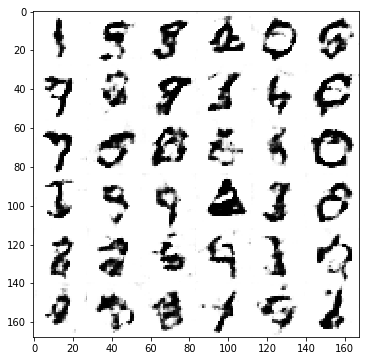

In [21]:
# Testing
# Generate images from noise, using the generator network.
n = 6
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
    # Noise input.
    z = np.random.uniform(-1., 1., size=[n, noise_dim])
    # Generate image from noise.
    g = sess.run(gen_sample, feed_dict={noise_input: z, batch_s: n, is_training:False})
    # Rescale values to the original [0, 1] (from tanh -> [-1, 1])
    g = (g + 1.) / 2.
    # Reverse colours for better display
    g = -1 * (g - 1)
    for j in range(n):
        # Draw the generated digits
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()

In [0]:
my_int_variable = tf.get_variable("my_int_variable", [1, 2, 3], dtype=tf.int32,
  initializer=tf.zeros_initializer)

In [23]:
my_int_variable

<tf.Variable 'my_int_variable:0' shape=(1, 2, 3) dtype=int32_ref>